# Градиентный бустинг своими руками

**Внимание:** в тексте задания произошли изменения - поменялось число деревьев (теперь 50), правило изменения величины шага в задании 3 и добавился параметр `random_state` у решающего дерева. Правильные ответы не поменялись, но теперь их проще получить. Также исправлена опечатка в функции `gbm_predict`.

В этом задании будет использоваться датасет `boston` из `sklearn.datasets`. Оставьте последние 25% объектов для контроля качества, разделив `X` и `y` на `X_train`, `y_train` и `X_test`, `y_test`.

Целью задания будет реализовать простой вариант градиентного бустинга над регрессионными деревьями для случая квадратичной функции потерь.

In [2]:
%matplotlib inline
from sklearn import datasets, model_selection, tree, metrics, ensemble, linear_model
from matplotlib import pyplot as plt
import seaborn
import numpy as np

## Задание 1

Как вы уже знаете из лекций, **бустинг** - это метод построения композиций базовых алгоритмов с помощью последовательного добавления к текущей композиции нового алгоритма с некоторым коэффициентом. 

Градиентный бустинг обучает каждый новый алгоритм так, чтобы он приближал антиградиент ошибки по ответам композиции на обучающей выборке. Аналогично минимизации функций методом градиентного спуска, в градиентном бустинге мы подправляем композицию, изменяя алгоритм в направлении антиградиента ошибки.

Воспользуйтесь формулой из лекций, задающей ответы на обучающей выборке, на которые нужно обучать новый алгоритм (фактически это лишь чуть более подробно расписанный градиент от ошибки), и получите частный ее случай, если функция потерь `L` - квадрат отклонения ответа композиции `a(x)` от правильного ответа `y` на данном `x`.

Если вы давно не считали производную самостоятельно, вам поможет таблица производных элементарных функций (которую несложно найти в интернете) и правило дифференцирования сложной функции. После дифференцирования квадрата у вас возникнет множитель 2 — т.к. нам все равно предстоит выбирать коэффициент, с которым будет добавлен новый базовый алгоритм, проигноируйте этот множитель при дальнейшем построении алгоритма.

In [3]:
data = datasets.load_boston()

X = data.data
y = data.target

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.25, shuffle = False)

$$L(y, a) = {(y - a)}^2$$
$$s = -gradL(y, a) = -2*(a - y) = -(a - y)$$

## Задание 2

Заведите массив для объектов `DecisionTreeRegressor` (будем их использовать в качестве базовых алгоритмов) и для вещественных чисел (это будут коэффициенты перед базовыми алгоритмами). 

В цикле от обучите последовательно 50 решающих деревьев с параметрами `max_depth=5` и `random_state=42` (остальные параметры - по умолчанию). В бустинге зачастую используются сотни и тысячи деревьев, но мы ограничимся 50, чтобы алгоритм работал быстрее, и его было проще отлаживать (т.к. цель задания разобраться, как работает метод). Каждое дерево должно обучаться на одном и том же множестве объектов, но ответы, которые учится прогнозировать дерево, будут меняться в соответствие с полученным в задании 1 правилом. 

Попробуйте для начала всегда брать коэффициент равным 0.9. Обычно оправдано выбирать коэффициент значительно меньшим - порядка 0.05 или 0.1, но т.к. в нашем учебном примере на стандартном датасете будет всего 50 деревьев, возьмем для начала шаг побольше.

В процессе реализации обучения вам потребуется функция, которая будет вычислять прогноз построенной на данный момент композиции деревьев на выборке `X`:

```
def gbm_predict(X):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]
(считаем, что base_algorithms_list - список с базовыми алгоритмами, coefficients_list - список с коэффициентами перед алгоритмами)
```

Эта же функция поможет вам получить прогноз на контрольной выборке и оценить качество работы вашего алгоритма с помощью `mean_squared_error` в `sklearn.metrics`. 

Возведите результат в степень 0.5, чтобы получить `RMSE`. Полученное значение `RMSE` — **ответ в пункте 2**.

In [4]:
base_algorithms_list = []
coefficients_list = [0.9 for n in range(50)]

def gbm_predict(X):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]

def gbm_fit():
    y_i = y_train
    for i in range(50):
        clf = tree.DecisionTreeRegressor(max_depth = 5, random_state = 42)
        clf.fit(X_train, y_i)
        base_algorithms_list.append(clf)
        y_predict = gbm_predict(X_train)
        y_i = y_train - y_predict
        
gbm_fit()

answer2 = metrics.mean_squared_error(y_test, gbm_predict(X_test))**0.5

print answer2

5.455565103009402


## Задание 3

Вас может также беспокоить, что двигаясь с постоянным шагом, вблизи минимума ошибки ответы на обучающей выборке меняются слишком резко, перескакивая через минимум. 

Попробуйте уменьшать вес перед каждым алгоритмом с каждой следующей итерацией по формуле `0.9 / (1.0 + i)`, где `i` - номер итерации (от 0 до 49). Используйте качество работы алгоритма как **ответ в пункте 3**. 

В реальности часто применяется следующая стратегия выбора шага: как только выбран алгоритм, подберем коэффициент перед ним численным методом оптимизации таким образом, чтобы отклонение от правильных ответов было минимальным. Мы не будем предлагать вам реализовать это для выполнения задания, но рекомендуем попробовать разобраться с такой стратегией и реализовать ее при случае для себя.

In [5]:
coefficients_list = [0.9 / (1.0 + i) for i in range(50)]

gbm_fit()

answer3 = metrics.mean_squared_error(y_test, gbm_predict(X_test))**0.5

print answer3

4.459381636757351


## Задание 4

Реализованный вами метод - градиентный бустинг над деревьями - очень популярен в машинном обучении. Он представлен как в самой библиотеке `sklearn`, так и в сторонней библиотеке `XGBoost`, которая имеет свой питоновский интерфейс. На практике `XGBoost` работает заметно лучше `GradientBoostingRegressor` из `sklearn`, но для этого задания вы можете использовать любую реализацию. 

Исследуйте, переобучается ли градиентный бустинг с ростом числа итераций (и подумайте, почему), а также с ростом глубины деревьев. На основе наблюдений выпишите через пробел номера правильных из приведенных ниже утверждений в порядке возрастания номера (это будет **ответ в п.4**):

    1. С увеличением числа деревьев, начиная с некоторого момента, качество работы градиентного бустинга не меняется существенно.

    2. С увеличением числа деревьев, начиная с некоторого момента, градиентный бустинг начинает переобучаться.

    3. С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга на тестовой выборке начинает ухудшаться.

    4. С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга перестает существенно изменяться

In [6]:
import xgboost as xgb

208.7550718653935
140.72611750189643
141.1937936391078
141.4001295403356
141.5341474253084
141.5920325695729
141.69851693961212
141.700189365282
141.77529680700388
141.84137596981245
141.861551239943
141.86426379734084
141.86669105526917
141.85841889906067
141.8578651547469
141.8359100304049
141.83076919161357
141.8124361351374
141.79815618141907
141.79921041875053


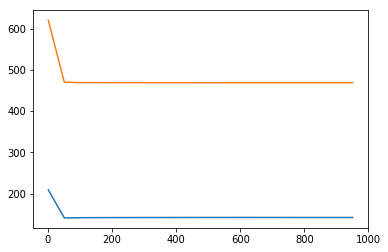

In [19]:
n_trees = np.arange(1, 1000, 50)
tree_depth = np.arange(1, 50, 5)

train_scores = []
test_scores = []

for n in n_trees:
    clf_xgb = xgb.XGBRegressor(n_estimators = n, learning_rate = 0.1, objective ='reg:squarederror')
    clf_xgb.fit(X_train, y_train)
    print metrics.mean_squared_error(y_test, clf_xgb.predict(X_test)**0.5)
    test_scores.append(metrics.mean_squared_error(y_test, clf_xgb.predict(X_test)**0.5))
    train_scores.append(metrics.mean_squared_error(y_train, clf_xgb.predict(X_train)**0.5))
    
plt.plot(n_trees, test_scores)
plt.plot(n_trees, train_scores)

139.4035677053256
143.5130715950041
143.9084516834126
143.76716433249703
143.7566970263766
143.7566970263766
143.7566970263766
143.7566970263766
143.7566970263766
143.7566970263766


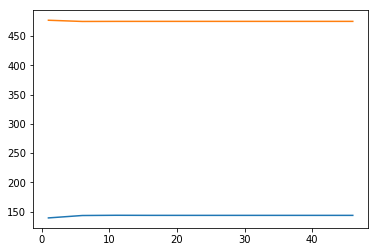

In [15]:
n_trees = np.arange(1, 1000, 50)
tree_depth = np.arange(1, 50, 5)

train_scores = []
test_scores = []

for n in tree_depth:
    clf_xgb = xgb.XGBRegressor(n_estimators = 30, learning_rate = 0.1, max_depth = n, objective ='reg:squarederror')
    clf_xgb.fit(X_train, y_train)
    print metrics.mean_squared_error(y_test, clf_xgb.predict(X_test)**0.5)
    test_scores.append(metrics.mean_squared_error(y_test, clf_xgb.predict(X_test)**0.5))
    train_scores.append(metrics.mean_squared_error(y_train, clf_xgb.predict(X_train)**0.5))
    
plt.plot(tree_depth, test_scores)
plt.plot(tree_depth, train_scores)

5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265 270 275 280 285 290 295 300 305 310 315 320 325 330 335 340 345 350 355 360 365 370 375 380 385 390 395 400 405 410 415 420 425 430 435 440 445 450 455 460 465 470 475 480 485 490 495 500 505 510 515 520 525 530 535 540 545 550 555 560 565 570 575 580 585 590 595 600 605 610 615 620 625 630 635 640 645 650 655 660 665 670 675 680 685 690 695 700 705 710 715 720 725 730 735 740 745 750 755 760 765 770 775 780 785 790 795 800 805 810 815 820 825 830 835 840 845 850 855 860 865 870 875 880 885 890 895 900 905 910 915 920 925 930 935 940 945 950 955 960 965 970 975 980 985 990 995

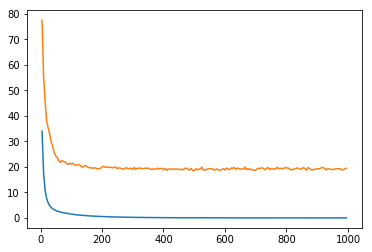

In [20]:
number_trees = np.arange(5, 1000, 5)
train_scores = []
test_scores = []

for tree in number_trees:
    print tree,
    clf = ensemble.GradientBoostingRegressor(n_estimators = tree)
    clf.fit(X_train, y_train)
    train_scores.append(metrics.mean_squared_error(y_train, clf.predict(X_train)))
    test_scores.append(metrics.mean_squared_error(y_test, clf.predict(X_test)))
    
plt.plot(number_trees, train_scores)
plt.plot(number_trees, test_scores)

## Задание 5

Сравните получаемое с помощью градиентного бустинга качество с качеством работы линейной регрессии. 

Для этого обучите `LinearRegression` из `sklearn.linear_model` (с параметрами по умолчанию) на обучающей выборке и оцените для прогнозов полученного алгоритма на тестовой выборке `RMSE`. Полученное качество - ответ в **пункте 5**. 

В данном примере качество работы простой модели должно было оказаться хуже, но не стоит забывать, что так бывает не всегда. В заданиях к этому курсу вы еще встретите пример обратной ситуации.

In [25]:
clf = linear_model.LinearRegression()
clf.fit(X_train, y_train)

metrics.mean_squared_error(y_test, clf.predict(X_test)) ** 0.5

8.254979753549103